In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
from mpmath import mp
import math
import csv

# Load Data
gene, taxon profile sizes and the similarity scores for eah pair

In [2]:
original_data = pd.read_csv("../../data/real_data/Scores_Sizes.txt", sep="\t", header=0, 
                    low_memory=True, memory_map=True, float_precision='round_trip')
gene_taxon_scores = original_data.copy()

#keep only columns of interest for current code
gene_taxon_scores.drop(columns=['Query Profile', 'Query Name', 'Corpus Profile',
                                'Corpus Profile Name', 'URI'], inplace=True)
gene_taxon_scores.rename(columns={'Query Profile Size':'taxon'}, inplace=True)
gene_taxon_scores.rename(columns={'Corpus Profile Size':'gene'}, inplace=True)
gene_taxon_scores.rename(columns={'Overall Similarity':'scores'}, inplace=True)

# Generate average similarity scores

We will compute the average score for each pair (gene_size, taxon_size), in order to manipulate data easily and have clearer view of how the data looks, since multiple pairs genes and taxons with same profile sizes can have same similarity scores.

In [3]:
def generate_avg_scores(gene_taxon_scores):

    if len(gene_taxon_scores) == 0:
        print('missing values for scores/taxon profile sizes/gene profile sizes')
        return

    gene_taxon_scores = gene_taxon_scores.groupby(['taxon','gene'], as_index=False)['scores'].mean() 
    gene_taxon_scores.rename(columns={'scores':'avg_scores'}, inplace=True)    
    return gene_taxon_scores

In [4]:
gene_taxon_avg_scores = generate_avg_scores(gene_taxon_scores)
print(len(gene_taxon_avg_scores))
print(gene_taxon_avg_scores.head())

32592
   taxon  gene  avg_scores
0      1     2    0.043367
1      1     3    0.080734
2      1     4    0.092635
3      1     5    0.104879
4      1     6    0.118577


# Data Transformation

Log Transformations
We will obtain the log for taxon/gene profile sizes, similarity score. These values will be used later in multiple linear regressions. 

## Log Transformation

Gene Logarithm, Taxon Logarithm, Average scores

In [5]:
geneLog = gene_taxon_avg_scores['gene'].apply(np.log)
taxonLog = gene_taxon_avg_scores['taxon'].apply(np.log)
avg_scoresLog = gene_taxon_avg_scores['avg_scores'].apply(np.log)

data = pd.DataFrame(
    {
        'gene': gene_taxon_avg_scores['gene'],
        'taxon': gene_taxon_avg_scores['taxon'],        
        'geneLog': geneLog,
        'taxonLog': taxonLog,
        'avg_scoresLog': avg_scoresLog,
        'z_values': '',
        'p_values': ''
    })
data.set_index(['geneLog', 'taxonLog'])
print(data.head())

   gene  taxon   geneLog  taxonLog  avg_scoresLog z_values p_values
0     2      1  0.693147       0.0      -3.138048                  
1     3      1  1.098612       0.0      -2.516600                  
2     4      1  1.386294       0.0      -2.379083                  
3     5      1  1.609438       0.0      -2.254949                  
4     6      1  1.791759       0.0      -2.132193                  


Build a histogram with the avg scores values

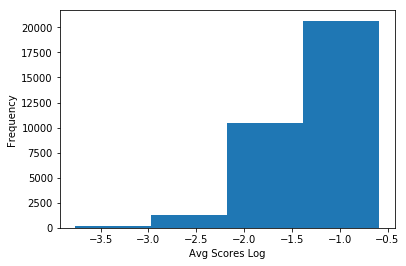

In [6]:
plt.hist(avg_scoresLog, bins=4)
plt.xlabel('Avg Scores Log')
plt.ylabel('Frequency')
plt.show()

In [7]:
def compute_std_dev():
    
    std_dev = 0
    mean = avg_scoresLog.mean()
    for score in avg_scoresLog:
        input = score-mean
        std_dev = std_dev + math.pow(input, 2)
    
    std_dev = std_dev/len(avg_scoresLog)
    std_dev = math.sqrt(std_dev)
    return std_dev    

In [8]:
def compute_z_values(const, coeff_taxonLog, coeff_geneLog, std_dev):
            
    z_values = []
    for i in range(len(avg_scoresLog)):
        observed_value = data.at[i,'avg_scoresLog']
        predicted_value = const+coeff_taxonLog*data.at[i,'taxonLog']+coeff_geneLog*data.at[i,'geneLog']        
        z_value = (observed_value - predicted_value)/std_dev
        z_values.append(z_value)
        data.at[i,'z_values'] = z_value      
        
    return z_values

These are the equation's coefficients obtained when we used WLS multiple linear regression on log gene size, log taxon size, log avg scores.

In [9]:
const = -2.903170
coeff_taxonLog = 0.252263
coeff_geneLog = 0.378430

We will compute p values for all the average scores. In order to do that, we will have to compute first the Z values for all avg scores.

## Computing Z values

In [10]:
std_deviation = compute_std_dev()
z_values = compute_z_values(const, coeff_taxonLog, coeff_geneLog, std_deviation)
for i in range(5):
    print(z_values[i]) 

-1.3377876270147617
-0.07850882344795908
-0.001422182212942472
0.10537222293078828
0.250026729902173


## Computing p values

In [11]:
p_values = []
for i in range(len(z_values)):    
    no = -math.e **(-data.at[i,'z_values']*math.pi/math.sqrt(6)-mp.euler)
    p_value = 1 - math.exp(no)
    p_values.append(p_value)
    data.at[i,'p_values'] = p_value      
for i in range(5):
    print(p_values[i]) 

0.9559434123982117
0.4625598690789904
0.4302083613522706
0.3876705944924903
0.33464163233360755


In [ ]:
merged_data = original_data.merge(data, left_on=['Query Profile Size', 'Corpus Profile Size'],
                           right_on=['taxon', 'gene'], how='left')
merged_data.drop(columns=['gene', 'taxon', 'avg_scoresLog', 'geneLog', 'taxonLog'], inplace=True)
merged_data.to_csv("../../data/real_data/Scores_Sizes_z_p_values.txt", index=False, 
              sep="\t", float_format='%.17f')